 #  <div style="text-align: center">Probability of Earthquake: EDA, FE, +5 Models </div> 
<img src='http://s8.picofile.com/file/8355280718/pro.png' width=400 height=400>
<div style="text-align:center"> last update: <b>25/03/2019</b></div>



You can Fork code  and  Follow me on:

> ###### [ GitHub](https://github.com/mjbahmani/10-steps-to-become-a-data-scientist)
> ###### [Kaggle](https://www.kaggle.com/mjbahmani/)
-------------------------------------------------------------------------------------------------------------
 <b> I hope you find this kernel helpful and some <font color='red'>UPVOTES</font> would be very much appreciated.</b>
    
 -----------

 <a id="top"></a> <br>
## Notebook  Content
1. [Introduction](#1)
1. [Load packages](#2)
    1. [import](21)
    1. [Setup](22)
    1. [Version](23)
1. [Problem Definition](#3)
    1. [Problem Feature](#31)
    1. [Aim](#32)
    1. [Variables](#33)
    1. [Evaluation](#34)
1. [Exploratory Data Analysis(EDA)](#4)
    1. [Data Collection](#41)
    1. [Visualization](#42)
        1. [Hist](#421)
        1. [Time to failure histogram](#422)
        1. [Distplot](#423)
        1. [kdeplot](#424)
    1. [Data Preprocessing](#43)
        1. [Create new feature](#431)
    1. [ML Explainability](#44)
        1. [Permutation Importance](#441)
        1. [Partial Dependence Plots](#442)
        1. [SHAP Values](#443)
1. [Model Development](#5)
    1. [SVM](#51)
    1. [LGBM](#52)
    1. [Catboost](#53)
1. [Submission](#6)
    1. [Blending](#61)
1. [References](#7)
    1. [References](#71)


 <a id="1"></a> <br>
## 1- Introduction
**Forecasting earthquakes** is one of the most important problems in **Earth science**. If you agree, the earthquake forecast is likely to be related to the concepts of **probability**. In this kernel, I try to look at the prediction of the earthquake with the **help** of the concepts of **probability** .
<img src='https://www.preventionweb.net/files/52472_largeImage.jpg' width=600 height=600 >
For anyone taking first steps in data science, **Probability** is a must know concept. Concepts of probability theory are the backbone of many important concepts in data science like inferential statistics to Bayesian networks. It would not be wrong to say that the journey of mastering statistics begins with **probability**.

Before starting, I have to point out that I used the following great kernel:
[https://www.kaggle.com/inversion/basic-feature-benchmark](https://www.kaggle.com/inversion/basic-feature-benchmark)

 <a id="2"></a> <br>
 ## 2- Load packages
  <a id="21"></a> <br>
## 2-1 Import

In [113]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor,Pool
import matplotlib.patches as patch
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import skew
from scipy.stats import norm
from scipy import linalg
from sklearn import tree
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import graphviz
import warnings
import random
import eli5
import shap  # package used to calculate Shap values
import time
import glob
import sys
import os

 <a id="22"></a> <br>
##  2-2 Setup

In [114]:
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)

 <a id="23"></a> <br>
## 2-3 Version


In [115]:
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('Python: {}'.format(sys.version))

pandas: 0.23.4
numpy: 1.16.2
Python: 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]


<a id="3"></a> 
<br>
## 3- Problem Definition
I think one of the important things when you start a new machine learning project is Defining your problem. that means you should understand business problem.( **Problem Formalization**)

Problem Definition has four steps that have illustrated in the picture below:
<img src="http://s8.picofile.com/file/8344103134/Problem_Definition2.png" width=400 height=400>

> <font color='red'>Note</font> : **Current scientific studies related to earthquake forecasting focus on three key points:** 
1. when the event will occur
1. where it will occur
1. how large it will be.


<a id="31"></a> 
### 3-1 Problem Feature

1.     Train.csv - A single, continuous training segment of experimental data.
1.     Test - A folder containing many small segments of test data.
1.     Slample_sumbission.csv - A sample submission file in the correct format.


<a id="32"></a> 
### 3-2 Aim
In this competition, you will address <font color='red'><b>WHEN</b></font> the earthquake will take place.

<a id="33"></a> 
### 3-3 Variables

1.     **acoustic_data** - the seismic signal [int16]
1.     **time_to_failure** - the time (in seconds) until the next laboratory earthquake [float64]
1.     **seg_id**- the test segment ids for which predictions should be made (one prediction per segment)


<a id="34"></a> 
### 3-4 Evaluation
Submissions are evaluated using the [**mean absolute error**](https://en.wikipedia.org/wiki/Mean_absolute_error) between the predicted time remaining before the next lab earthquake and the act remaining time.
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/3ef87b78a9af65e308cf4aa9acf6f203efbdeded'>

<a id="4"></a> 
## 4- Exploratory Data Analysis(EDA)
 In this section, we'll analysis how to use graphical and numerical techniques to begin uncovering the structure of your data. 
 
1. Which variables suggest interesting relationships?
1. Which observations are unusual?
1. Analysis of the features!
By the end of the section, you'll be able to answer these questions and more, while generating graphics that are both insightful and beautiful.  then We will review analytical and statistical operations:

1. Data Collection
1. Visualization
1. Data Preprocessing
1. Data Cleaning

 <a id="41"></a> <br>
## 4-1 Data Collection

What we have in input!

In [116]:
print(os.listdir("../input/"))

['test', 'train.csv', 'sample_submission.csv']


In [117]:
%%time
train = pd.read_csv('../input/train.csv' , dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 22s, sys: 20.2 s, total: 2min 42s
Wall time: 2min 42s


In [118]:
print("Train has: rows:{} cols:{}".format(train.shape[0], train.shape[1]))

Train has: rows:629145480 cols:2


In [119]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [120]:
print("submission has: rows:{} cols:{}".format(submission.shape[0], submission.shape[1]))

submission has: rows:2624 cols:1


### There are 2624 files in test.zip.

In [121]:
len(os.listdir(os.path.join('../input/', 'test')))

2624

Also we have **2624**  row same as number of test files in submission , so this clear that we should predict **time_to_failure** for all of test files.

## Memory usage: 3.5 GB

In [122]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float32
dtypes: float32(1), int16(1)
memory usage: 3.5 GB


In [123]:
#train.describe()

In [124]:
train.shape

(629145480, 2)

### Wow! so large(rows:629145480 columns:2) for playing with it, let's select just 150000 rows!

In [125]:
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


 <a id="42"></a> <br>
## 4-2 Visualization
Because the size of the database is very large, for the visualization section, we only need to select a small subset of the data.

In [126]:
# we change the size of Dataset due to play with it (just loaded %0001)
mini_train= pd.read_csv("../input/train.csv",nrows=150000)

In [127]:
mini_train.describe()

,acoustic_data,time_to_failure
count,150000.000000000000000,150000.000000000000000
mean,4.884113333333334,1.450182493841733
std,5.101106130607257,0.011248415135459
min,-98.000000000000000,1.430797185900000
25%,3.000000000000000,1.440397885225000
50%,5.000000000000000,1.449998584550000
75%,7.000000000000000,1.459599283875000
max,104.000000000000000,1.469099983200000


In [128]:
mini_train.shape

(150000, 2)

In [129]:
mini_train.isna().sum()

acoustic_data      0
time_to_failure    0
dtype: int64

In [130]:
type(mini_train)

pandas.core.frame.DataFrame

<a id="421"></a> 
### 4-2-1 Hist

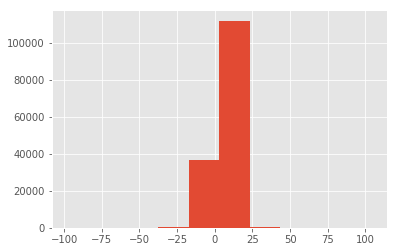

In [131]:
#acoustic_data means signal
mini_train["acoustic_data"].hist();

<a id="422"></a> 
### 4-2-2 Time to failure histogram

Text(0.5, 1.0, 'time_to_failure histogram')

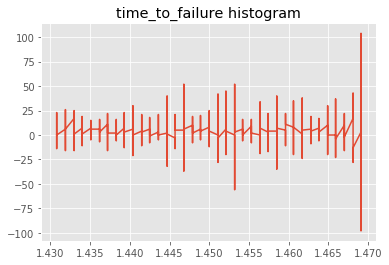

In [132]:
plt.plot(mini_train["time_to_failure"], mini_train["acoustic_data"])
plt.title("time_to_failure histogram")

<a id="423"></a> 
### 4-2-3 Distplot

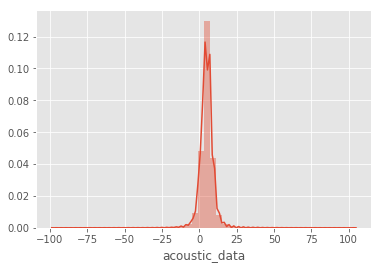

In [133]:
sns.distplot(mini_train["acoustic_data"])

<a id="424"></a> 
### 4-2-4 kdeplot

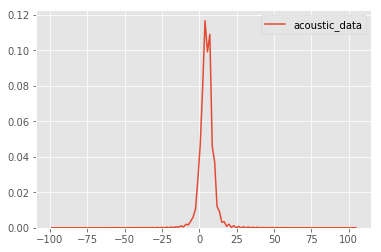

In [134]:
sns.kdeplot(mini_train["acoustic_data"] )

 <a id="43"></a> <br>
## 4-3 Data Preprocessing


Because we have only one feature(**acoustic_data**), and the size of the training set is very large( more that 60000000 rows), it is a good idea to reduce the size of the training set with making new segment  and also to increase the number of attributes by using **statistical attributes**.

In [135]:
# based on : https://www.kaggle.com/inversion/basic-feature-benchmark
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))
segments

4194

In [136]:
X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min','sum','skew','kurt'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

### y_train is our target for prediction

In [137]:
y_train.head()

,time_to_failure
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


### our train set with 4 new feature

In [138]:
X_train.head()

,ave,std,max,min,sum,skew,kurt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 <a id="431"></a> <br>
### 4-3-1 Create New Features

> <font color='red'>Note:</font>  
**tqdm** means "progress" in Arabic (taqadum, تقدّم) and is an abbreviation for "I love you so much" in Spanish (te quiero demasiado). Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you're done! [https://tqdm.github.io/](https://tqdm.github.io/)

In [139]:
%%time
for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'sum'] = x.sum()
    X_train.loc[segment, 'skew'] =skew(x)
    X_train.loc[segment, 'kurt'] = kurtosis(x)

100%|██████████| 4194/4194 [00:33<00:00, 125.15it/s]

CPU times: user 33.9 s, sys: 0 ns, total: 33.9 s
Wall time: 33.5 s


In [140]:
X_train.head()

,ave,std,max,min,sum,skew,kurt
0,4.884113333333334,5.101089126891323,104.0,-98.0,732617.0,-0.024060926015874,33.661319221480703
1,4.725766666666667,6.588801819164257,181.0,-154.0,708865.0,0.390556598755942,98.755185259155695
2,4.906393333333333,6.967373808828945,140.0,-106.0,735959.0,0.217388387534031,33.554052910588105
3,4.902240000000000,6.922282112791032,197.0,-199.0,735336.0,0.757269963614698,116.544246785098039
4,4.908720000000000,7.301085852684289,145.0,-126.0,736308.0,0.064530423958889,52.976098920993913


In [141]:
y_train.head()

,time_to_failure
0,1.430797219276428
1,1.391498923301697
2,1.353196144104004
3,1.313797831535339
4,1.274399518966675


### Cheking missing Data

In [142]:
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        # written by MJ Bahmani
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [143]:
check_missing_data(X_train)

False

### Now we must create our X_test for submission

In [144]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [145]:
X_test.head()

,ave,std,max,min,sum,skew,kurt
seg_id,,,,,,,
seg_00030f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seg_0012b5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seg_00184e,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seg_003339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seg_0042cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
%%time
for seg_id in  tqdm(X_test.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'sum'] = x.sum()
    X_test.loc[seg_id, 'skew'] =skew(x)
    X_test.loc[seg_id, 'kurt'] = kurtosis(x)

100%|██████████| 2624/2624 [01:04<00:00, 40.46it/s]

CPU times: user 1min 2s, sys: 1.46 s, total: 1min 4s
Wall time: 1min 4s


In [147]:
X_test.shape

(2624, 7)

Now we have all of the data frames for applying ML algorithms. just adding some feature scaling.

In [148]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [149]:
X_test_scaled = scaler.transform(X_test)

In [150]:
X=X_train.copy()
y=y_train.copy()

 <a id="44"></a> <br>
## 4-4 ML Explainability
In this section, I want to try extract insights from models with the help of this excellent [Course](https://www.kaggle.com/learn/machine-learning-explainability) in Kaggle. The Goal behind of ML Explainability for Earthquake is:

1. Extract insights from models.
1. Find the most inmortant feature in models.
1. Affect of each feature on the model's predictions.

 <a id="441"></a> <br>
### 4-4-1 Permutation Importance
In this section we will answer following question:

What features have the biggest impact on predictions?

how to extract insights from models?

In [151]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestRegressor(random_state=0).fit(train_X, train_y)

Here is how to calculate and show importances with the [eli5](https://eli5.readthedocs.io/en/latest/) library:

In [152]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [153]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=7)

Weight,Feature
0.7188 ± 0.1008,std
0.1431 ± 0.0624,kurt
0.0610 ± 0.0247,max
0.0202 ± 0.0096,min
0.0053 ± 0.0162,skew
0.0012 ± 0.0051,ave
0.0001 ± 0.0189,sum


 <a id="442"></a> <br>
### 4-4-2 Partial Dependence Plots
While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions. and partial dependence plots are calculated after a model has been fit. [partial-plots](https://www.kaggle.com/dansbecker/partial-plots)

In [154]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

For the Partial of explanation, I use a Decision Tree which you can see below.

In [155]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=X.columns)

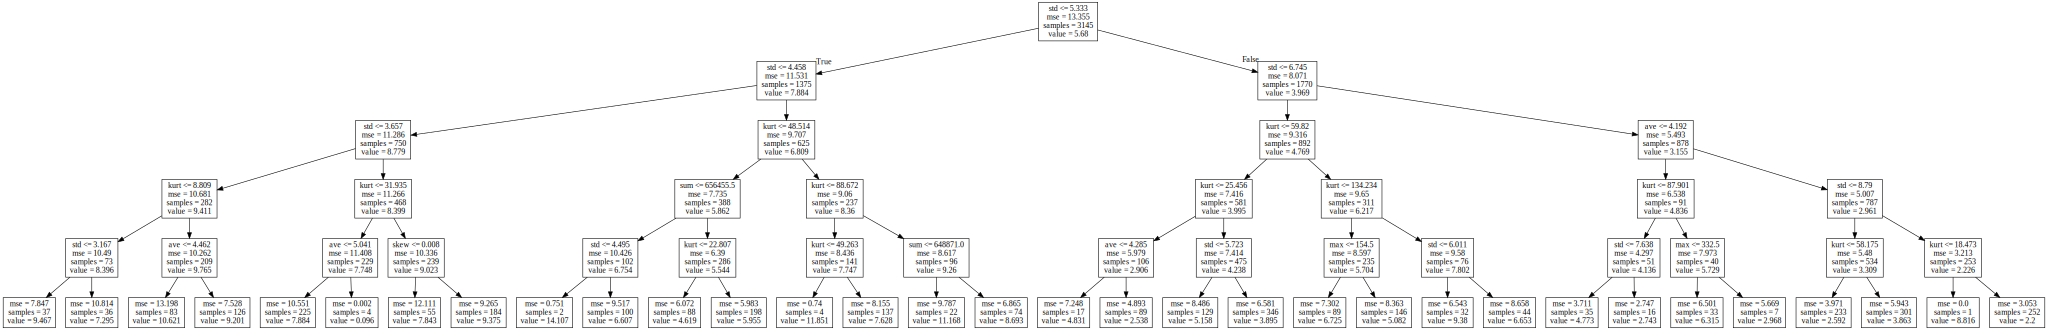

In [156]:
graphviz.Source(tree_graph)

 <a id="443"></a> <br>
### 4-4-3 SHAP Values
SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods [1-7] and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see the SHAP NIPS paper for details).

In [157]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


tree_model.predict(data_for_prediction_array);

In [158]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

>**Note**: Shap can answer to this qeustion : how the model works for an individual prediction?

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### 4-4-4 pdpbox

In [ ]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=X.columns, feature='std')

# plot it
pdp.pdp_plot(pdp_goals, 'std')
plt.show()

In [ ]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rfc_model, dataset=val_X, model_features=X.columns, feature='kurt')

# plot it
pdp.pdp_plot(pdp_goals, 'kurt')
plt.show()

<a id="5"></a> <br>
# 5- Model Development

<a id="51"></a> <br>
# 5-1 SVM

In [ ]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred_svm = svm.predict(X_train_scaled)

In [ ]:
score = mean_absolute_error(y_train.values.flatten(), y_pred_svm)
print(f'Score: {score:0.3f}')

<a id="52"></a> <br>
# 5-2 LGBM

 Defing folds for cross-validation

In [ ]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)

LGBM params

In [ ]:
params = {'objective' : "regression", 
               'boosting':"gbdt",
               'metric':"mae",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.001,
               'num_leaves' : 52,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.85,
               'bagging_freq' : 1,
               'bagging_fraction' : 0.85,
               'min_data_in_leaf' : 10,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : -1}

In [ ]:
%%time
y_pred_lgb = np.zeros(len(X_test_scaled))
for fold_n, (train_index, valid_index) in tqdm(enumerate(folds.split(X))):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
    model = lgb.LGBMRegressor(**params, n_estimators = 22000, n_jobs = -1)
    model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
            
    y_pred_valid = model.predict(X_valid)
    y_pred_lgb += model.predict(X_test_scaled, num_iteration=model.best_iteration_) / folds.n_splits

<a id="53"></a> <br>
# 5-3 Catboost 

In [ ]:
train_pool = Pool(X,y)
cat_model = CatBoostRegressor(
                               iterations=3000,# change 25 to 3000 to get best performance 
                               learning_rate=0.03,
                               eval_metric='MAE',
                              )
cat_model.fit(X,y,silent=True)
y_pred_cat = cat_model.predict(X_test)

<a id="6"></a> <br>
# 6- submission

### submission for svm

In [ ]:
y_pred_svm= svm.predict(X_test_scaled)

In [ ]:
submission['time_to_failure'] = y_pred_cat
submission.to_csv('submission_svm.csv')

### Submission for LGBM

In [ ]:
submission['time_to_failure'] = y_pred_lgb
submission.to_csv('submission_lgb.csv')

### Submission for Catboost

In [ ]:
submission['time_to_failure'] = y_pred_cat
submission.to_csv('submission_cat.csv')

### Submission for Randomforest

In [ ]:
y_pred_rf=rfc_model.predict(X_test_scaled)

In [ ]:

submission['time_to_failure'] = y_pred_rf
submission.to_csv('submission_rf.csv')

<a id="61"></a> <br>
# 6-1 Blending

In [ ]:
blending = y_pred_svm*0.5 + y_pred_lgb*0.5 
submission['time_to_failure']=blending
submission.to_csv('submission_lgb_svm.csv')

In [ ]:
blending = y_pred_svm*0.5 + y_pred_cat*0.5 
submission['time_to_failure']=blending
submission.to_csv('submission_cat_svm.csv')

you can follow me on:
> ###### [ GitHub](https://github.com/mjbahmani/)
> ###### [Kaggle](https://www.kaggle.com/mjbahmani/)

 <b>I hope you find this kernel helpful and some <font color='red'>UPVOTES</font> would be very much appreciated.<b/>
 

<a id="7"></a> <br>
# 7-References
1. [Basic Probability Data Science with examples](https://www.analyticsvidhya.com/blog/2017/02/basic-probability-data-science-with-examples/)
1. [How to self learn statistics of data science](https://medium.com/ml-research-lab/how-to-self-learn-statistics-of-data-science-c05db1f7cfc3)
1. [Probability statistics for data science- series](https://towardsdatascience.com/probability-statistics-for-data-science-series-83b94353ca48)
1. [basic-statistics-in-python-probability](https://www.dataquest.io/blog/basic-statistics-in-python-probability/)
1. [tutorialspoint](https://www.tutorialspoint.com/python/python_poisson_distribution.htm)

## 7-1 Kaggle Kernels
In the end , I want to thank all the kernels I've used in this notebook
1. [https://www.kaggle.com/inversion/basic-feature-benchmark](https://www.kaggle.com/inversion/basic-feature-benchmark)
1. [https://www.kaggle.com/dansbecker/permutation-importance](https://www.kaggle.com/dansbecker/permutation-importance)

Go to first step: [Course Home Page](https://www.kaggle.com/mjbahmani/10-steps-to-become-a-data-scientist)

Go to next step : [Titanic](https://www.kaggle.com/mjbahmani/a-comprehensive-ml-workflow-with-python)


### Not Completed yet!!!